# Assignment: Capstone
# Project Objective: Predict Home Price Index (HPI) Based on Major Crime Incidents (MCI) in Toronto
## Name: Allan Salamanca
## Course: Data Science Diploma Program
## Due Date: June 09, 2025

In [80]:
# Import all packages required for the analysis.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
import seaborn as sns
import calendar

from scipy.stats import pearsonr
from scipy import stats

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib.ticker import StrMethodFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Advance Modelling

## Next Steps

#### Our current model struggles with high property values.  We notice this in values over $ 2 million.  Since we know that some of our independent variables have a higher influence on our dependent variable (Attribute & Municipality), we need to account for these in our advanced modelling.  Additionally, since property values have a wide range, we can consider scaling the data using a Log, using a percentage change in house price instead.  Logging “shrinks” the extreme values, allowing the model to focus on the majority instead of the outliers.

#### Next Steps:
- Log Housing Price Values
- Compare and assess more advanced modelling, such as RandomForestRegressor, DecisionTreeRegressor, or XGBoost.
- Hyperparameter Tuning.


# Log the Housing Value

#### In our initial baseline model, we observed an accuracy rate of 77% with poor RMSE and MAE scores.  It under-predicts high-value properties.  Before moving on to the advanced model, we can apply a log transformation to the house values to try to normalize the data.

#### Logging the house values will reduce the skewness of the outliers (high value properties), and can reduce the distortion of the regression results.  Logging should improve the linearity, stabilize large variances and enhance our accuracy.

In [85]:
# Log the housing value

In [86]:
df_v5 = pd.read_csv('../data/df_v5.csv')

In [87]:
df_v5_log = df_v5.copy()

df_v5_log["LogValue"] = np.log(df_v5_log["Value"])

In [88]:
# Check the first few rows.
print(df_v5_log[["Value", "LogValue"]].head())

      Value   LogValue
0  849400.0  13.652285
1  677500.0  13.426165
2  415100.0  12.936275
3  326300.0  12.695572
4  805300.0  13.598970


In [89]:
df_v5_log.head()

,Attribute_HPI - Apartment,Attribute_HPI - Single-Family Attached,Attribute_HPI - Single-Family Detached,Attribute_HPI - Townhouse,Crime Count,Toronto Municipality_Toronto C01,Toronto Municipality_Toronto C02,Toronto Municipality_Toronto C03,Toronto Municipality_Toronto C04,Toronto Municipality_Toronto C06,...,Toronto Municipality_Toronto W04,Toronto Municipality_Toronto W05,Toronto Municipality_Toronto W06,Toronto Municipality_Toronto W07,Toronto Municipality_Toronto W08,Toronto Municipality_Toronto W09,Toronto Municipality_Toronto W10,Value,Year,LogValue
0,0.0,0.0,1.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,849400.0,2015.0,13.652285
1,0.0,1.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,677500.0,2015.0,13.426165
2,0.0,0.0,0.0,1.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415100.0,2015.0,12.936275
3,1.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326300.0,2015.0,12.695572
4,0.0,0.0,1.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805300.0,2015.0,13.598970


In [90]:
# Check the data.
df_v5_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 43 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Attribute_HPI - Apartment               16800 non-null  float64
 1   Attribute_HPI - Single-Family Attached  16800 non-null  float64
 2   Attribute_HPI - Single-Family Detached  16800 non-null  float64
 3   Attribute_HPI - Townhouse               16800 non-null  float64
 4   Crime Count                             16800 non-null  float64
 5   Toronto Municipality_Toronto C01        16800 non-null  float64
 6   Toronto Municipality_Toronto C02        16800 non-null  float64
 7   Toronto Municipality_Toronto C03        16800 non-null  float64
 8   Toronto Municipality_Toronto C04        16800 non-null  float64
 9   Toronto Municipality_Toronto C06        16800 non-null  float64
 10  Toronto Municipality_Toronto C07        16800 non-null  fl

# OLS Regression on Log Values

In [92]:
# Now, we can do a similar linear regression model on our baseline modelling but instead use the log Value.

attr_cols  = [c for c in df_v5_log if c.startswith('Attribute')]
muni_cols  = [c for c in df_v5_log if c.startswith('Toronto Municipality')]

X = df_v5_log[attr_cols + muni_cols + ['Crime Count',"Year"]]
X = sm.add_constant(X)
y = df_v5_log['LogValue']

model_log = sm.OLS(y, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     3027.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:27:06   Log-Likelihood:                 5459.3
No. Observations:               16800   AIC:                        -1.084e+04
Df Residuals:                   16760   BIC:                        -1.053e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

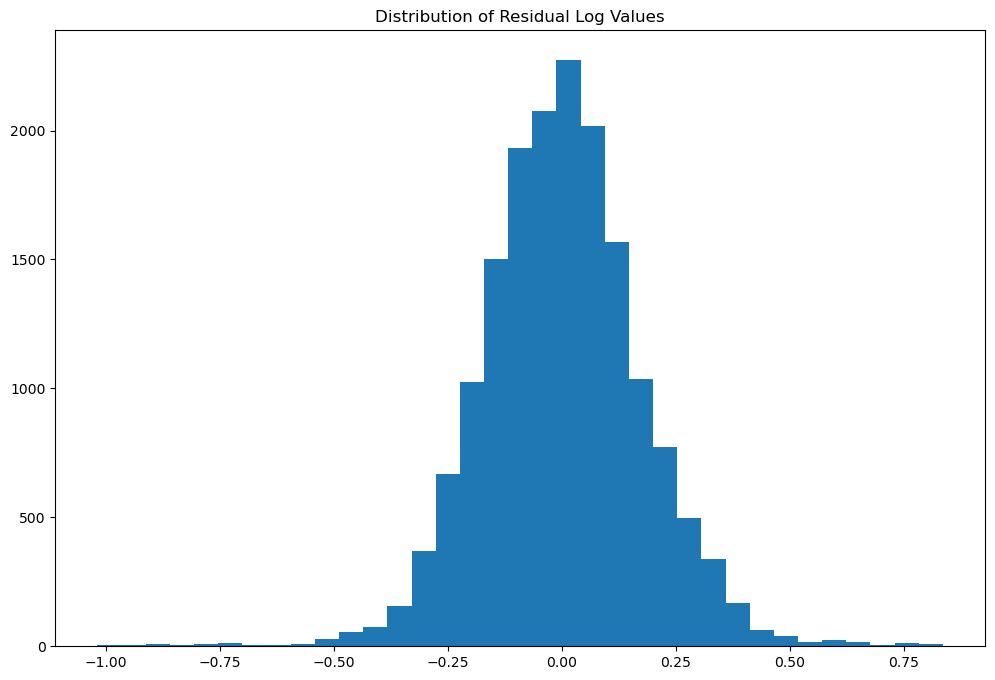

In [93]:
# Plotting the residuals for logged model.

plt.figure(figsize=(12, 8))
plt.hist(model_log.resid, bins = 35)
plt.title('Distribution of Residual Log Values')
plt.show()

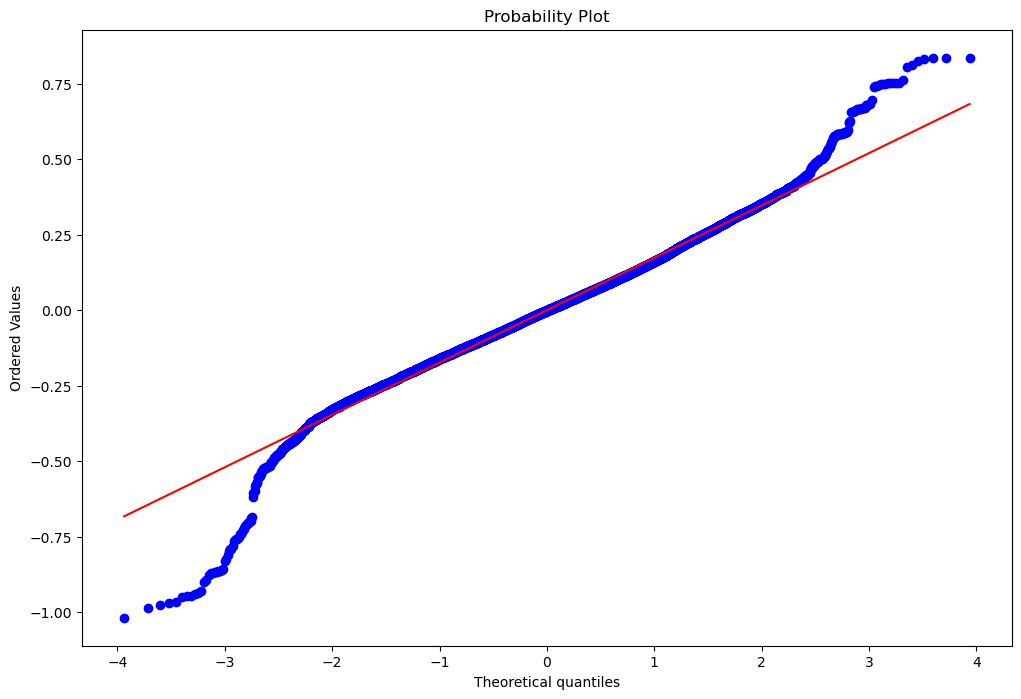

In [94]:
# Normal Q-Q plot
plt.figure(figsize=(12, 8))
stats.probplot(model_log.resid, dist="norm", plot=plt)
plt.show()

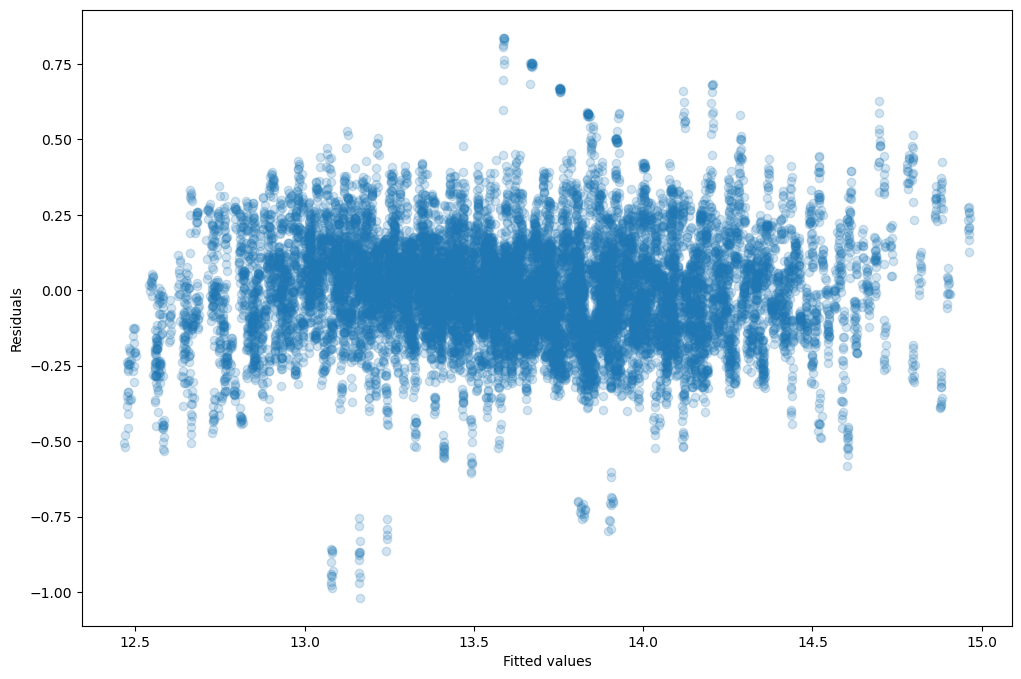

In [95]:
# Plot the residuals and the predicted values

plt.figure(figsize=(12, 8))
plt.scatter(model_log.fittedvalues, model_log.resid, alpha=0.2)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Scikit Learn's Linear Regression on Log Values

In [97]:
# Create train and test split.

attr_cols  = [c for c in df_v5_log if c.startswith('Attribute')]
muni_cols  = [c for c in df_v5_log if c.startswith('Toronto Municipality')]

X2 = df_v5_log[attr_cols + muni_cols + ['Crime Count',"Year"]]
y2 = df_v5_log['LogValue']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [98]:
# Create a pipeline to scale and fit the model.

pipe_log = make_pipeline(
    StandardScaler(),      
    LinearRegression()     
)

pipe_log.fit(X2_train, y2_train)
y2_train_pred = pipe_log.predict(X2_train)
y2_test_pred  = pipe_log.predict(X2_test)

# Review test and train score.
train_r2 = r2_score(y2_train, y2_train_pred)
test_r2  = r2_score(y2_test,  y2_test_pred)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y2_test, y2_test_pred))
mae  = mean_absolute_error(y2_test, y2_test_pred)

# Print results.
print(f"Train R² : {train_r2: .2%}")
print(f"Test  R² : {test_r2 : .2%}")
print(f"Test RMSE: {rmse:.3f}")   # e.g. 0.264
print(f"Test MAE : {mae :.3f}")   # e.g. 0.202

Train R² :  87.44%
Test  R² :  88.02%
Test RMSE: 0.173
Test MAE : 0.134


In [99]:
# Convert the log RMSE and MAE score to dollar value.

y_test_pred_dollar = np.exp(y2_test_pred)
y_test_dollar      = np.exp(y2_test)

rmse_dollar = np.sqrt(mean_squared_error(y_test_dollar, y_test_pred_dollar))
mae_dollar  = mean_absolute_error(y_test_dollar, y_test_pred_dollar)

print(f"Converted RMSE: ${rmse_dollar:,.0f}")
print(f"Converted MAE : ${mae_dollar:,.0f}")

Converted RMSE: $203,328
Converted MAE : $129,722


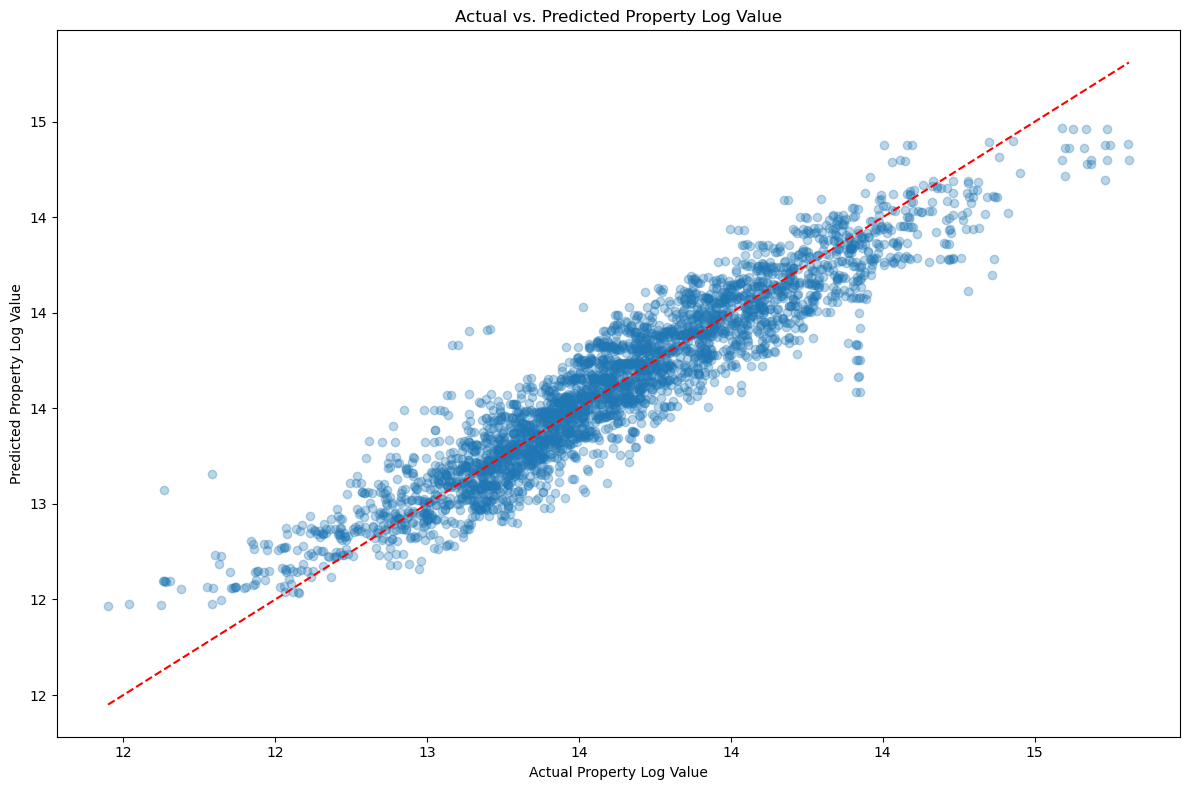

In [100]:
# Plot to visualize the results.

plt.figure(figsize=(12, 8))
plt.scatter(y2_test, y2_test_pred, alpha=0.3)

# Line for "perfect prediction"
plt.plot([y2_test.min(), y2_test.max()],
         [y2_test.min(), y2_test.max()],'r--')

plt.xlabel("Actual Property Log Value")
plt.ylabel("Predicted Property Log Value")
plt.title("Actual vs. Predicted Property Log Value")
fmt = StrMethodFormatter("{x:,.0f}")     # e.g. $1,234,567
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.tight_layout()
plt.show()

#### Logging the data, we can now see that we have a better R-squared score, increasing to 0.87 from 0.77.  Additionally, our RMSE and MAE scores have improved, with the variances decreasing.  

#### When comparing it to the previous Actual vs. Predicted graph, we can now see that the logged version is more compressed and better fits a linear regression.  Due to this, high-valued properties carry less weight, and the model will not drastically underperform high property values.  

#### Next, we can utilize this data to perform our advanced modelling.

# Advanced Modelling

#### For our advanced modelling, I will be examining three different machine learning tools: Decision Tree Regressor, Random Forest Regressor, and eXtreme Gradient Boosting.

- The Decision Tree Regressor splits the data into smaller groups based on specific features (e.g., year or house prices), and at each split, it tries to reduce the errors in predictions based on the group of data.  It makes predictions by breaking down the data into decision rules and is utilized for basic regression problems.
- The Random Forest Regressor is similar to the Decision Tree. Still, instead of utilizing a single decision tree, it combines predictions from multiple decision trees using a random subset of data.  The output prediction is the average of the decision trees combined, providing a more stable result.
- eXtreme Gradient Boosting takes both models and improves upon them.  It's an advanced model that creates numerous small decision trees and learns from its mistakes to produce more accurate predictions.  As it builds each decision tree and "learns" from its mistakes, over time, as more decision trees are created, it becomes better at predicting.  Then, it combines all the trees to make a final prediction.

#### We run all three models into a Pipeline and utilize a GridSearchCV function to help us find the best results and parameters.

In [104]:
# Create a pipeline.

pipe_search = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())  # Placeholder, and will be overwritten by param_grid.
])

- n_estimators - number of individual decision trees in a model
- max_depth - number of "decision points" in a tree
- min_samples_split - number of samples in a data subset
- learning_rate - how much each new tree "corrects" the previous one

In [106]:
# Set the parameters for each model.

param_grid = [
    {
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [4, 8, 12, None],
        'model__min_samples_split': [2, 5, 10]
    },
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__max_depth': [4, 8, 12, None],
        'model__min_samples_split': [2, 5, 10]
    },
    {
        'model': [XGBRegressor(objective='reg:squarederror', random_state=42)],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [4, 8, 12, None],
        'model__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
    }
]

#### We can set up a GridSearch, utilizing 5-fold cross-validation, and search for the best R² score.  Our initial baseline logged model was up to 0.87, so let's see which model can yield the best result.

In [108]:
grid = GridSearchCV(pipe_search, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X2_train, y2_train)

print("Best Estimator:", grid.best_estimator_)
print("Best Score (CV R²):", grid.best_score_)
print("Best Params:", grid.best_params_)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_job

#### Based on the GridSearchCV function, we can see that the best model estimator is the eXtreme Gradient Boosting.  Additionally, suggested parameters to use include a 0.2 learning rate, a maximum depth of 8, and 300 n_estimators.  

#### Can see that the r2 value is now very close to 0.98 vs. 0.87 previously.  Lastly, we can see a an improvement on RMSE and MAE scores, now the varainces are much lower.

In [110]:
# Predict using the test set (logged)
y2_test_pred = grid.predict(X2_test)

# Reverse log transformation for predictions and actuals
y2_test_exp = np.exp(y2_test)
y2_test_pred_exp = np.exp(y2_test_pred)

# Calculate r2 on the logged data set.
r2 = r2_score(y2_test, y2_test_pred)
rmse_log = np.sqrt(mean_squared_error(y2_test, y2_test_pred))
mae_log = mean_absolute_error(y2_test, y2_test_pred)

# Convert RMSE and MAE in original dollar scale
rmse_dollars = np.sqrt(mean_squared_error(y2_test_exp, y2_test_pred_exp))
mae_dollars = mean_absolute_error(y2_test_exp, y2_test_pred_exp)

# Print both versions
print(f"Test R² (log scale): {r2:.2%}")
print(f"Test RMSE (log scale): {rmse_log:.3f}")
print(f"Test MAE (log scale): {mae_log:.3f}")
print(f"Test RMSE in $: ${rmse_dollars:,.0f}")
print(f"Test MAE in $: ${mae_dollars:,.0f}")

Test R² (log scale): 98.84%
Test RMSE (log scale): 0.054
Test MAE (log scale): 0.039
Test RMSE in $: $61,482
Test MAE in $: $37,070


#### Optionally, we can visualize the yield of n_estimators and learning rate.  As shown in the visual below, increasing the estimators and learning rate doesn't yield more accuracy beyond a n_estimator of 300 and a learning rate of 0.2.

In [112]:
# Visualize the yield.
# Create a dataframe of the grid results.

results_df = pd.DataFrame(grid.cv_results_)

In [113]:
xgb_results = results_df[results_df['param_model'].apply(lambda x: x.__class__.__name__ == 'XGBRegressor')]

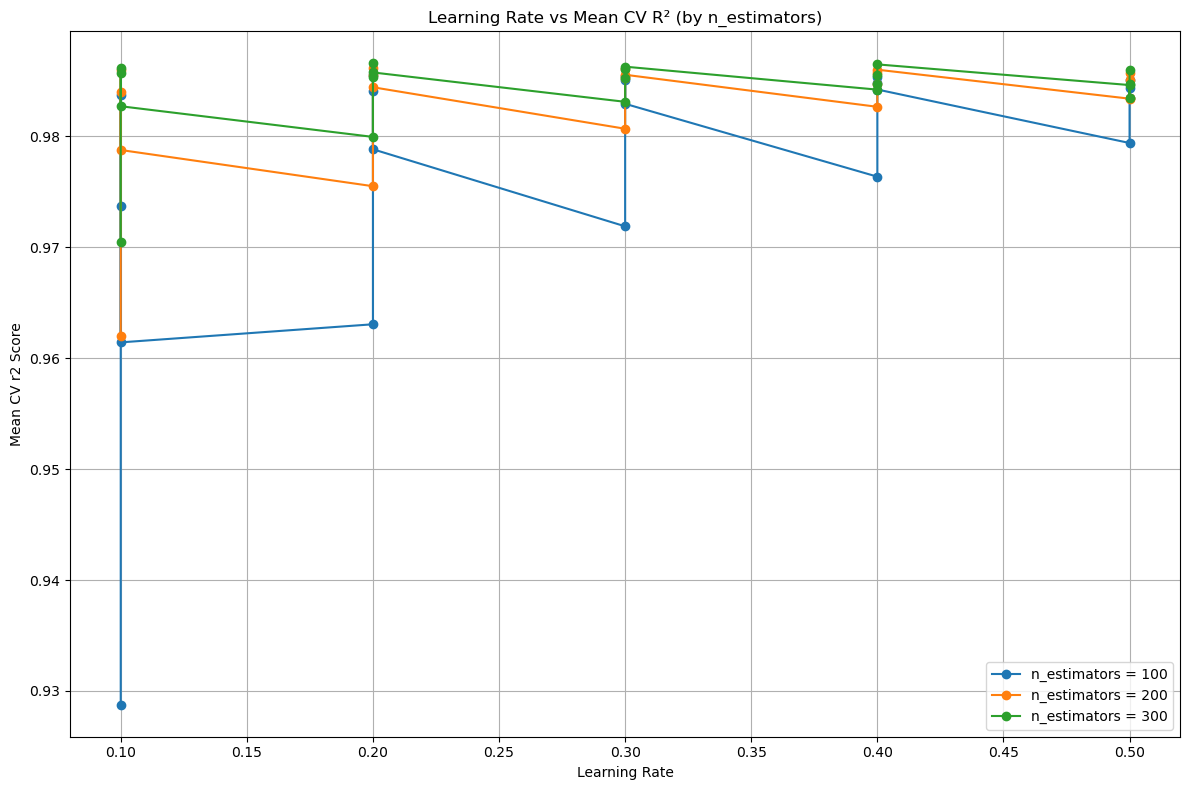

In [114]:
# Plot the results.

plt.figure(figsize=(12, 8))

for n in sorted(xgb_results['param_model__n_estimators'].unique()):
    subset = xgb_results[xgb_results['param_model__n_estimators'] == n]
    plt.plot(subset['param_model__learning_rate'],
             subset['mean_test_score'],
             marker='o',
             label=f'n_estimators = {n}')

plt.title('Learning Rate vs Mean CV R² (by n_estimators)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean CV r2 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Next, we can quickly plot the actual versus predicted values to see how much improvement has been made from the previous linear regression model.


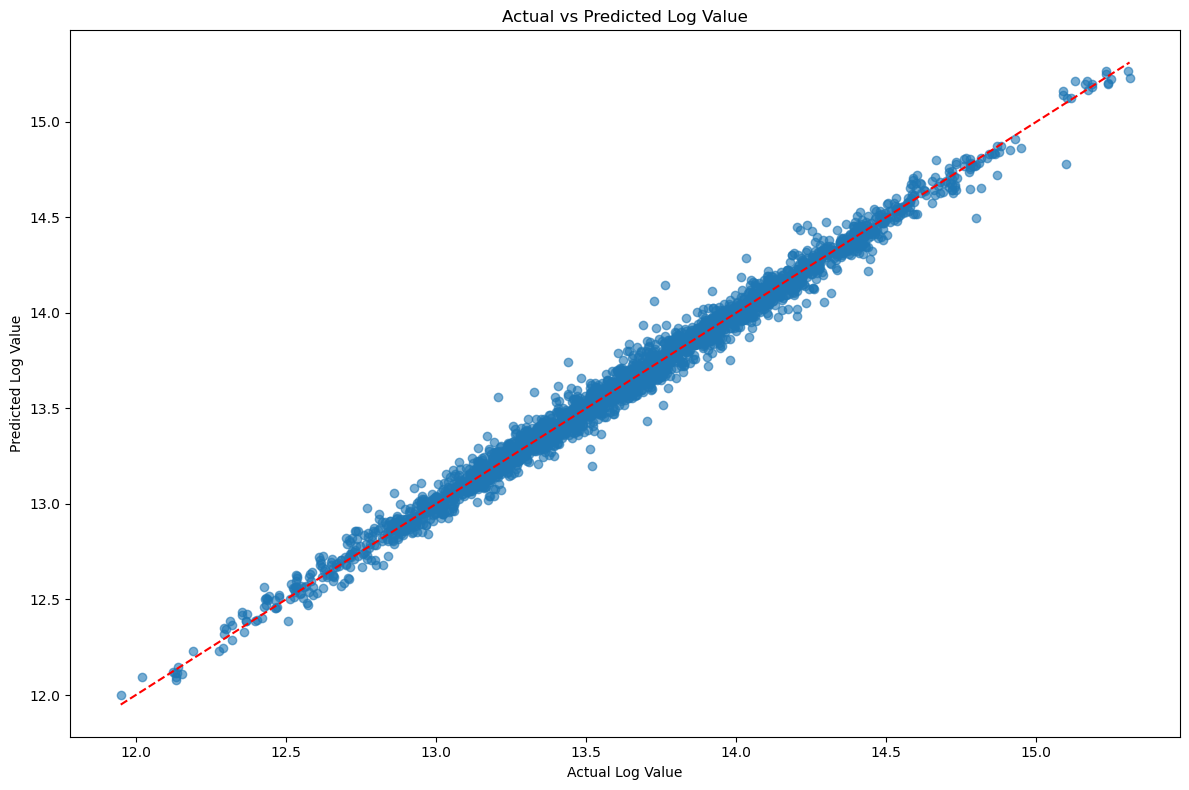

In [116]:
# Plot to visualize the results.

plt.figure(figsize=(12, 8))
plt.scatter(y2_test, y2_test_pred, alpha=0.6)
plt.plot([y2_test.min(), y2_test.max()],
         [y2_test.min(), y2_test.max()],
         'r--')
plt.xlabel("Actual Log Value")
plt.ylabel("Predicted Log Value")
plt.title("Actual vs Predicted Log Value")
# Grid removed ↓↓↓
# plt.grid(True)
plt.tight_layout()
plt.show()

#### We can see that the XGBoost Regressor predicts housing prices with very high accuracy. After applying a log transformation and using GridSearch, it achieved an R² of 98.84%, meaning it explains nearly all the variation in prices. Now, the average error went from 246K to 61K, increasing the confidence level in the model. The results demonstrate a strong correlation between predicted and actual prices, enhancing the reliability of the tool.

# Create and Exporting a Pickle File


#### Now that we have identified our model, we can export this to a Pickle file, which can feed our dashboarding tool and API.

In [120]:
best_model = grid.best_estimator_

In [121]:
best_model.fit(X2_train, y2_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [122]:
import pickle

# Place "best_model" in a pickle file.
with open("house_price_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model pickled to house_price_model.pkl")

✅ Model pickled to house_price_model.pkl


In [123]:
# Test the results locally.

# Load data.
with open("house_price_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Select sample
sample_X = X2_train.iloc[[0]]  # keep as one-row DataFrame

# Predict the log(price)
log_pred = loaded_model.predict(sample_X)

# Invert the log transform to get the actual price
price_pred = np.exp(log_pred)

# Print results
print("Input features:\n", sample_X)
print(f"Predicted log-price: {log_pred[0]:.4f}")
print(f"Predicted house price: ${price_pred[0]:,.2f}")

Input features:
       Attribute_HPI - Apartment  Attribute_HPI - Single-Family Attached  \
5040                        0.0                                     0.0   

      Attribute_HPI - Single-Family Detached  Attribute_HPI - Townhouse  \
5040                                     1.0                        0.0   

      Toronto Municipality_Toronto C01  Toronto Municipality_Toronto C02  \
5040                               0.0                               0.0   

      Toronto Municipality_Toronto C03  Toronto Municipality_Toronto C04  \
5040                               0.0                               0.0   

      Toronto Municipality_Toronto C06  Toronto Municipality_Toronto C07  ...  \
5040                               0.0                               0.0  ...   

      Toronto Municipality_Toronto W03  Toronto Municipality_Toronto W04  \
5040                               0.0                               0.0   

      Toronto Municipality_Toronto W05  Toronto Municipalit